The strength of linear regression models lies in their ability to provide straightforward and interpretable solutions that not only predict future outcomes but also provide insight into the underlying processes that create these outcomes. One of the reasons why linear regression models are so commonplace is that by interpreting estimated coefficients, they can shed light on an underlying relationship. The process of interpreting the relationship between estimated coefficients and outcomes is called **inference**.

In this checkpoint, we learn to answer questions like:

* How much does an increase in an explanatory variable affect the explained variable?
* How can we single out the effect of a specific variable by isolating its effects from those of other variables that also affect the outcome?

The answers to these questions can drive a lot of business value. Think about a company that likes to measure the performance of its advertising expenditures. Are radio advertisements more effective in attracting new customers than  Facebook ads? For a thousand dollars spent on TV ads, how many products does the company sell? And, how can we distinguish whether the new customers are the result of TV ads or Google ads?

Before quantifying the relationship between the individual features and the target variable, we first need to determine whether that feature has a significant role in explaining the target. So, we start with the discussion of the statistical significance.

Main topics we'll cover in this checkpoint are:

* statistical significance
* t-test
* t-value
* p-value
* inference and the relationship between estimated coefficients and the target
* interpreting continuous and categorical variables
* interpreting interaction terms
* interpreting constants

This checkpoint ends with three assignments in which you interpret the coefficients for some models.

## Statistical significance of individual coefficients

Estimating parameters in a linear regression model does not guarantee that the estimated coefficients are statistically significant!

When estimating a parameter, the ultimate objective is to find its true value in the population. More often than not, we need to work with a sample rather than the actual population, and we estimate the coefficients using a sample. For an individual coefficient to be **statistically significant**, it must have a relatively high value with respect to its standard deviation. In other words, it must help explain some information in the outcome.

We use **t-tests** to determine if an individual coefficient estimate is statistically different from zero. This is a way of quantifying a measure of *unique* variance in the outcome as a function of the parameter, *after controlling for the variance explained by the other parameters*.

![t_test](assets/t_test.png)

For instance, in a linear regression with the yellow circle as the outcome, the total variance explained by the model is represented by the intersection of the yellow, blue, and pink feature circles. However, the statistical test of the significance of the blue circle will be done on *only* the green area where blue and yellow overlap, ignoring the area of shared overlap among blue, pink, and yellow. Similarly, the statistical test of the significance of the pink circle will be done on *only* the orange area where the pink and yellow overlap.

A non-significant parameter does not contribute to the explanation of the information about the outcome variable and can be discarded with little to no decrease in the model's explanatory power. Moreover, we should treat statistically insignificant coefficients as if they are zero when interpreting the model.

When we estimate a linear regression model using statsmodels, the `summary()` function returns t-statistics and associated p-values. **P-values** are easier to read than t-values. The p-value associated with a t-test quantifies the likelihood that the estimated coefficient is actually equal to zero in the real population. The lower the p-value, the more significant the coefficient is. As a general rule of thumb, when the p-value of a coefficient is less than or equal to 0.1, we say that the coefficient is statistically significant. However, it's admirable to have a p-value that is less than or equal to 0.05.


## Our new medical costs model

We use the medical costs dataset to illustrate how to interpret the estimated coefficients in a linear regression model. Here, we load the medical costs dataset and build a new regression model including continuous variables as well as the categorical ones. In the dataset, we have two continuous variables: age and BMI (body mass index). In this new model, we add them alongside the "is_male" and "is_smoker" dummies as explanatory variables.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medicalcosts'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

insurance_df = pd.read_sql_query('select * from medicalcosts',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


insurance_df.head(10)

age     sex    bmi  children smoker     region   charges
0   19  female 27.900         0    yes  southwest 16884.900
1   18    male 33.770         1     no  southeast  1725.550
2   28    male 33.000         3     no  southeast  4449.460
3   33    male 22.705         0     no  northwest 21984.500
4   32    male 28.880         0     no  northwest  3866.860
5   31  female 25.740         0     no  southeast  3756.620
6   46  female 33.440         1     no  southeast  8240.590
7   37  female 27.740         3     no  northwest  7281.510
8   37    male 29.830         2     no  northeast  6406.410
9   60  female 25.840         0     no  northwest 28923.100

In [2]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex, drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker, drop_first=True)

In [3]:
# Y is the target variable
Y = insurance_df['charges']

# X is the feature set
X = insurance_df[['is_male','is_smoker', 'age', 'bmi']]

# We add constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     986.5
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:17:48   Log-Likelihood:                -13557.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1333   BIC:                         2.715e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.163e+04    947.267    -12.281      0.0

The estimated model is: 

$$ charges = -11633.50 - 109.04is\_male + 23833.87is\_smoker + 259.45age + 323.05bmi \qquad(eq.1)$$

is_male and is_smoker variables are dummies, but the age and BMI variables are continuous. Interpreting dummies is slightly different than interpreting continuous variables. In this checkpoint, we'll cover them separately. But before moving forward, we need to understand how to isolate the mutual effects of multiple variables on the target.

## OLS regression as a controlled experiment

A **controlled experiment** is a scientific experiment type where only the effect of a single factor is measured by controlling other factors that also affect the outcome. For example, if we want to measure the effect of light on the growth of a specific plant, then we need to set up two environments where every factor like humidity, soil, etc. is the same except for the amount of light.

We can think of the estimated linear regression models as a controlled experiment. When we estimate the coefficients of a model using OLS, we actually get coefficient estimates that are isolated from each other. That is to say, the coefficient of a feature measures the effect of that variable on the outcome variable by holding all other variables constant at their means. So we can interpret an estimated coefficient as the measure of the relationship between that feature and the target after stripping out the effects of all other features. 

## Interpreting the dummy variables

Consider the coefficients of the dummy variables in (eq.1). The coefficient of is_male is âˆ’109.04, and the coefficient of is_smoker is 23833.87. Moreover, we see that the p-value of is_smoker is very close to zero, whereas the p-value of is_male is 0.745. This implies that the coefficient of is_male is effectively zero from a statistical point of view. It's simply not significant, and we can say that there appears to be no relationship between medical costs and biological sex.

This is an okay hunch but requires further confirmation. It's possible that the model equation may play some role in this conclusion. We'll see later in this checkpoint that by including an additional variable in the model, the coefficient of is_male can be made statistically significant.

On the other hand, smoking is a significant factor in the medical costs charged. According to our estimation, the medical costs of people who smoke are $23,833.87 dollars more than those who don't smoke __on average__. Recall that when we include dummies in a model, we always hold one group out. In this example, the holdout group is the non-smokers, and we need to read the coefficient of the is_smoker dummy variable relative to this holdout group.

## Interpreting continuous variables

Now, let's interpret the coefficients of the continuous variables in (eq.1). First, both the age and BMI variables are statistically significant as the p-values are very close to zero. The coefficient of age is 259.45. As a person's age increases by one year, her/his costs increase by \\$259.4 on average. Similarly, as BMI increases by one point, medical costs increase by \\$323.05 on average.

**Note:** Sometimes, transforming the target and features can lead to a clearer interpretation. For example, if we take the logarithms of a target and a feature and estimate the model after that, we can interpret the "coefficient" of that feature like this: a percentage increase in the value of the original feature (not log transformed) results in the "coefficient" percentage change in the original target (not log transformed). If you wonder why this is the case, you can read this [StackOverflow question](https://stats.stackexchange.com/questions/244199/why-is-it-that-natural-log-changes-are-percentage-changes-what-is-about-logs-th).



## Interpreting the interaction terms

So far, we've interpreted categorical and continuous variables one at a time. But sometimes we need to model **interactions** in order to best explain outcomes. By putting interaction variables in a linear regression model, we can capture non-linear relationships between the target and the features. For example, from (eq.1), we know the difference of average costs between smokers and non-smokers. However, if we believe that the costs of smokers would increase as the BMI of a person increases (because the probability of having a heart attack increases) more than the non-smokers, we need to add the interaction of BMI and the is_smoker dummy to the model.

Mathematically, we capture the interaction of two variables by multiplying them. Now, let's create an interaction variable and add it to our model:

In [4]:
# Y is the target variable
Y = insurance_df['charges']

# This is the interaction between bmi and smoking
insurance_df["bmi_is_smoker"] = insurance_df.bmi * insurance_df.is_smoker

# X is the feature set
X = insurance_df[['is_male','is_smoker', 'age', 'bmi', "bmi_is_smoker"]]

# We add a constant to the model as it's a best practice
# to do so every time!
X = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1365.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:43:16   Log-Likelihood:                -13265.
No. Observations:                1338   AIC:                         2.654e+04
Df Residuals:                    1332   BIC:                         2.657e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2071.0750    840.644     -2.464

The estimated model is: 

$$ charges = -2071.07 - 473.49is\_male - 20190is\_smoker + 266.37age + 7.96bmi + 1435.60bmi\_is\_smoker \qquad(eq.2)$$

First, notice that all the coefficients have changed with respect to the previous model. This is because every time we add or drop a variable, the model specification changes. This results in different point estimates for the coefficients. The same is also true for the statistical significance of the coefficients. For example, the coefficient of the is_male dummy now turns out to be statistically significant. 

After we included the interaction of BMI and is_smoker to the model, we see that BMI is no longer statistically significant. This is probably because BMI mainly affects medical charges when the is_smoker variable is true. As we see, the coefficient of the interaction variable is statistically significant. 

According to our results, a one-point increase in BMI results in \\$1,435.60 greater increase for smokers than for non-smokers. However, we should read this result with caution. On face, a \\$1,436.60 increase sounds like a lot for a single-point increase in BMI. That's probably because of the fact that our target variable (charges) is very skewed. So, linear regression comes up with estimates that measure the relationship on average.

We can illustrate the effect of interaction in a graph as follows:

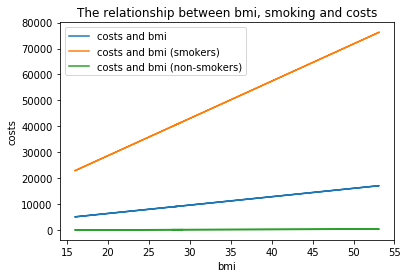

In [5]:

costs_bmi = insurance_df.bmi * 323.0511
costs_bmi_smokers = insurance_df.bmi * 1435.6081
costs_bmi_non_smokers = insurance_df.bmi * 7.9686


plt.plot(insurance_df.bmi, costs_bmi)
plt.plot(insurance_df.bmi, costs_bmi_smokers)
plt.plot(insurance_df.bmi, costs_bmi_non_smokers)
plt.legend(["costs and bmi", "costs and bmi (smokers)", "costs and bmi (non-smokers)"])
plt.xlabel("bmi")
plt.ylabel("costs")
plt.title("The relationship between bmi, smoking and costs")

plt.show()

The <font color=blue>blue line</font> is the relationship we estimated in (eq.1) between BMI and charges. Since the interaction of BMI and smoking is not included in this model, the estimated value represents an averaged figure for BMI. The <font color=green>green line</font> is the relationship we estimated in (eq.2) between the charges and BMI for non-smokers, and the <font color=orange>orange line</font> represents the relationship between charges and BMI for smokers. As we see, the increase in charges with an increase in BMI is higher for smokers than non-smokers. Because of the interaction term in (eq.2), we can now distinguish the effects of an increase in BMI on charges between smokers and non-smokers. Notice that the blue line lies between the green and the orange lines as it measures the averaged effect of BMI on charges both for smokers and non-smokers.

## Interpreting the constant

Constants in linear regression models correspond to the outcome value that is expected to happen when all the explanatory variables take a zero value. In a simple linear regression setting (when there is only a single explanatory variable), constants correspond to the point the fitted curve crosses the y-axis. 

Although it's easy to visualize the constant term in simple linear regression settings, it gets harder to grasp what a constant term means if there are many features included in the model. For example, if a dummy variable is included in a model, then one category should be excluded from the model as we explained before. In this case, the constant term also includes information regarding the holdout category. Hence, a lot of factors may be captured by the constant.

The safest way to think about the constant term is to think of it as the bias. Remember that in the previous checkpoint we said that the constant terms make the residuals zero on average. In this sense, the constant takes the bias from residuals to itself. This is why the constant is also called bias!


## Assignments

To close out this checkpoint, you're going to do three assignments. For the first assignment, you'll write up a short answer to a question.  For the second two assignments, you'll do your work in Jupyter notebooks.


Please submit links to all your work below. This is not a graded checkpoint, but you should discuss your solutions with your mentor. Also, when you're done, compare your work to [these example solutions](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/4.solution_understanding_the_relationship.ipynb).

### 1. Interpretation and significance

Suppose that we would like to know how much families in the US are spending on recreation annually. We've estimated the following model:

$$ expenditure = 873 + 0.0012annual\_income + 0.00002annual\_income^2 - 223.57have\_kids $$

*expenditure* is the annual spending on recreation in US dollars, *annual_income* is the annual income in US dollars, and *have_kids* is a dummy variable indicating the families with children. Interpret the estimated coefficients. What additional statistics should be given in order to make sure that your interpretations make sense statistically. Write up your answer.

### 2. Weather model

In this exercise, you'll work with the historical temperature data from the previous checkpoint. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* First, load the dataset from the **weatherinszeged** table from Thinkful's database.
* Build a linear regression model where your target variable is the difference between the *apparenttemperature* and the *temperature*. As explanatory variables, use *humidity* and *windspeed*. Now, estimate your model using OLS. Are the estimated coefficients statistically significant? Are the signs of the estimated coefficients in line with your previous expectations? Interpret the estimated coefficients. What are the relations between the target and the explanatory variables? 
* Next, include the interaction of *humidity* and *windspeed* to the model above and estimate the model using OLS. Are the coefficients statistically significant? Did the signs of the estimated coefficients for *humidity* and *windspeed* change? Interpret the estimated coefficients.

###  3. House prices model

In this exercise, you'll interpret your house prices model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Run your house prices model again and interpret the results. Which features are statistically significant, and which are not?
* Now, exclude the insignificant features from your model. Did anything change?
* Interpret the statistically significant coefficients by quantifying their relations with the house prices. Which features have a more prominent effect on house prices?
* Do the results sound reasonable to you? If not, try to explain the potential reasons.